<pre>
<strong><font color='green'>TensorFlow Lite </font></strong>now supports converting weights to 16-bit floating point values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 2x reduction in model size. Some hardware, like GPUs, can compute natively in this reduced precision arithmetic, realizing a speedup over traditional floating point execution. The Tensorflow Lite GPU delegate can be configured to run in this way. However, a model converted to float16 weights can still run on the CPU without additional modification: the float16 weights are upsampled to float32 prior to the first inference. This permits a significant reduction in model size in exchange for a minimal impacts to latency and accuracy.

Refer - https://www.tensorflow.org/lite/performance/post_training_float16_quant
</pre>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/

Mounted at /gdrive
/gdrive


In [ ]:
!pip install keras==2.3.1
!pip install tensorflow_io

In [17]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
!pip install pydicom
import pydicom
from pydicom import dcmread
from sklearn.utils import resample # Handle Imbalance
import pathlib
import PIL
import tensorflow_io as tfio
import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_last')
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy


In [9]:
os.chdir('/gdrive/MyDrive/Image_Segementation_CS2/')

In [10]:
# read csv file
df_main  = pd.read_csv('Main_CS2_SIIM_All.csv')
df_downsampled  = pd.read_csv('Main_CS2_SIIM.csv')

In [ ]:
df_main.head()

,UID,Encoded_pixel,Path
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,siim/dicom-images-train/1.2.276.0.7230010.3.1....


# **MODEL**


#  UNET -  ChexNet as Bonebone

In [19]:
# Metrics 
def dice_coeff(actual,predicted,smooth=1):
  Actual = K.flatten(actual)
  Predict = K.flatten(predicted)
  intersection  = K.sum(Actual *Predict)
  return ((2.* intersection + smooth) / (K.sum(Actual) +K.sum(Predict) +smooth))

In [21]:
Segmentation_model   = tf.keras.models.load_model('new_model_save_test/best_models_Unet_ChexNet.hdf5', custom_objects={'dice_coeff':dice_coeff}) # # Best Segmentation model
classification_model = tf.keras.models.load_model('best_models_classification.h5') # Loading the best Classification model

<strong>Post-training float16 quantization
 </strong>

In [22]:
# Using the Python TFLiteConverter, you can now convert the trained model into a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(Segmentation_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpe_r0owv6/assets


In [23]:
tflite_models_dir = pathlib.Path("/tmp/siim_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [24]:
tflite_model_file = tflite_models_dir/"siim_model.tflite"
tflite_model_file.write_bytes(tflite_model)

48311532

In [25]:
'''
To instead quantize the model to float16 on export, first set the optimizations flag to use default optimizations. 
Then specify that float16 is the supported type on the target platform:
'''
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [26]:
'''
Finally, convert the model like usual. 
Note, by default the converted model will still use float input and outputs for invocation convenience
'''
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"siim_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmp9gjxdrf5/assets


INFO:tensorflow:Assets written to: /tmp/tmp9gjxdrf5/assets


24255840

In [ ]:
# Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [28]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [29]:
#Function-  Classification_Segmentation   ---> 
'''Here we are doing two actions, First we predicting whether given image has affected by pneumothorax or not.
    If Yes, Display X-ray with highlighted affected part.
    If No, Display image as it is. 😀
'''

def Classification_Segmentation(X):
  img = tf.io.read_file(X)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image_1=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image_1,axis=0)

  if classification_model.predict(image)>=0.5:
    print("Pneumothorax has been detected")
    test_image = np.expand_dims(image_1, axis=0).astype(np.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    mask=predictions[0]
    mask=(mask>0.5).astype(np.uint8)

    plt.figure(figsize=(20,6)) 
    plt.title("X-ray image with mask(Predicted)")
    plt.imshow(np.squeeze(image),cmap='gray')
    plt.imshow(np.squeeze(mask),cmap='Reds',alpha=0.3)
    return plt.show()

  else:
    plt.figure(figsize=(20,6))
    print('Person is Healthy, No Pneumothorax is detected')
    plt.imshow(np.squeeze(image),cmap='gray')
    return plt.show()

Pneumothorax has been detected


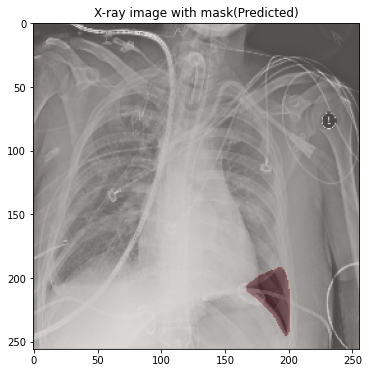

--- 0.5943212509155273 seconds --- for execution


In [31]:
start_time = time.time()
Classification_Segmentation(df_downsampled['Path'][45])
print("--- %s seconds --- for execution" % (time.time() - start_time))

## Without Quantizsation

In [32]:
#Function-2 ---> If Function 1 predict, image having Pneumothorax, then highlight the affected parts by red color.
def Classification_Segmentation(X):
  img = tf.io.read_file(X)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image,axis=0)

  if classification_model.predict(image)>=0.5:
    print("Pneumothorax has been detected")
    mask=Segmentation_model.predict(image)
    mask=(mask>0.5).astype(np.uint8)

    plt.figure(figsize=(20,6)) 
    plt.title("X-ray image with mask(Predicted)")
    plt.imshow(np.squeeze(image),cmap='gray')
    plt.imshow(np.squeeze(mask),cmap='Reds',alpha=0.3)
    return plt.show()

  else:
    plt.figure(figsize=(20,6))
    print('Person is Healthy, No Pneumothorax is detected')
    plt.imshow(np.squeeze(image),cmap='gray')
    return plt.show()

Pneumothorax has been detected


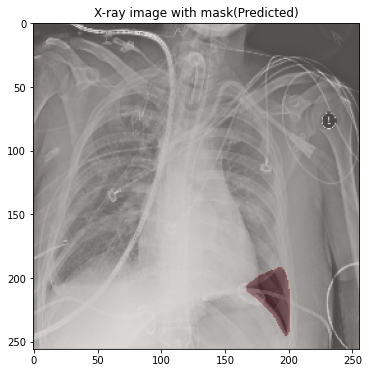

--- 3.2286911010742188 seconds --- for execution


In [33]:
start_time = time.time()
Classification_Segmentation(df_downsampled['Path'][45])
print("--- %s seconds --- for execution" % (time.time() - start_time))

# **SUMMARY**

After postquantizsation, we reduced the execution time from 3.2 seconds to 0.5 seconds and result also similar